In [19]:
# library section dump necessary library here
import pandas as pd
import numpy as np
import yfinance as yf
import talib
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [20]:
# Set random seed for reproducibility
np.random.seed(42)

In [21]:
# 1. Data Collection
def fetch_stock_data(ticker='AAPL', start_date='2020-01-01', end_date='2025-05-19'):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]

In [22]:
# 2. Feature Engineering
def engineer_features(data):
    df = data.copy()
    
    # Ensure 1D arrays with float64 dtype for TA-Lib
    close_array = df['Close'].to_numpy().ravel().astype(np.float64)  # Convert to float64
    volume_array = df['Volume'].to_numpy().ravel().astype(np.float64)  # Convert to float64
    
    # Technical Indicators
    df['SMA_20'] = talib.SMA(close_array, timeperiod=20)
    df['EMA_20'] = talib.EMA(close_array, timeperiod=20)
    df['RSI'] = talib.RSI(close_array, timeperiod=14)
    df['MACD'], df['MACD_Signal'], _ = talib.MACD(close_array, fastperiod=12, slowperiod=26, signalperiod=9)
    df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = talib.BBANDS(close_array, timeperiod=20)
    df['OBV'] = talib.OBV(close_array, volume_array)
    
    # Volume-based features
    df['Volume_ROC'] = df['Volume'].pct_change() * 100
    
    # Price-based features
    df['Price_Lag1'] = df['Close'].shift(1)
    df['Price_Lag5'] = df['Close'].shift(5)
    
    # Drop NaN values
    df = df.dropna()
    return df

In [23]:
# 3. Prepare data for Prophet
def prepare_prophet_data(data):
    df_prophet = data[['Close']].reset_index()
    df_prophet.columns = ['ds', 'y']
    # Add regressors
    regressors = ['SMA_20', 'EMA_20', 'RSI', 'MACD', 'OBV', 'Volume_ROC']
    for reg in regressors:
        df_prophet[reg] = data[reg].values
    return df_prophet

In [24]:
# 4. Prepare data for GRU
def prepare_gru_data(data, seq_length=60):
    features = ['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'OBV', 'Volume_ROC']
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[features])
    
    X, y = [], []
    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i-seq_length:i])
        y.append(scaled_data[i, 0])  # Predict Close price
    X, y = np.array(X), np.array(y)
    
     # Train-test split aligned with Prophet
    train_size = int(0.8 * len(data)) - seq_length  # Adjust for sequence length
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler, data.index[seq_length:][train_size:]

In [25]:
# 5. Prophet Model
def train_prophet_model(df_prophet):
    model = Prophet(daily_seasonality=True)
    regressors = ['SMA_20', 'EMA_20', 'RSI', 'MACD', 'OBV', 'Volume_ROC']
    for reg in regressors:
        model.add_regressor(reg)
    
    train_size = int(0.8 * len(df_prophet))
    train_data = df_prophet[:train_size]
    model.fit(train_data)
    
    # Predict
    future = df_prophet[train_size:]
    forecast = model.predict(future)
    return forecast['yhat'].values, model, df_prophet.index[train_size:]

In [26]:
# 6. GRU Model
def train_gru_model(X_train, X_test, y_train, seq_length):
    model = Sequential([
        GRU(50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
        Dropout(0.2),
        GRU(50),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    
    predictions = model.predict(X_test, verbose=0)
    return predictions.flatten(), model


In [27]:
# 7. Stacking Regression
def stack_models(prophet_preds, gru_preds, y_test):
    # Trim predictions to the same length
    min_length = min(len(prophet_preds), len(gru_preds), len(y_test))
    prophet_preds = prophet_preds[:min_length]
    gru_preds = gru_preds[:min_length]
    y_test = y_test[:min_length]
    
    X_stack = np.column_stack((prophet_preds, gru_preds))
    stack_model = StackingRegressor(
        estimators=[('lr1', LinearRegression()), ('lr2', LinearRegression())],
        final_estimator=LinearRegression()
    )
    stack_model.fit(X_stack, y_test)
    stack_preds = stack_model.predict(X_stack)
    return stack_preds

In [28]:
# 8. Evaluation Metrics
def calculate_metrics(y_true, y_pred, returns):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    directional_acc = np.mean(np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])) * 100
    
    # Risk Metrics
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) != 0 else 0
    cum_returns = np.cumprod(1 + returns) - 1
    max_drawdown = np.min(cum_returns) if len(cum_returns) > 0 else 0
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Directional Accuracy': directional_acc,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

In [29]:
# 9. Main Execution
def main():
    # Fetch and preprocess data
    data = fetch_stock_data()
    engineered_data = engineer_features(data)
    
    # Prepare data for models
    prophet_data = prepare_prophet_data(engineered_data)
    X_train, X_test, y_train, y_test, scaler, gru_test_index = prepare_gru_data(engineered_data)
    
    # Train models
    prophet_preds, prophet_model, prophet_test_index = train_prophet_model(prophet_data)
    gru_preds, gru_model = train_gru_model(X_train, X_test, y_train, X_test.shape[1])
   
    # Inverse transform GRU predictions
    gru_preds_full = np.zeros((len(gru_preds), X_test.shape[2]))
    gru_preds_full[:, 0] = gru_preds
    gru_preds = scaler.inverse_transform(gru_preds_full)[:, 0]

    # Align predictions using the minimum length
    min_length = min(len(prophet_preds), len(gru_preds))
    prophet_preds = prophet_preds[:min_length]
    gru_preds = gru_preds[:min_length]
    y_test = engineered_data['Close'].iloc[-min_length:].to_numpy()
    test_index = engineered_data.index[-min_length:]
    
    # Stacking
    stack_preds = stack_models(prophet_preds, gru_preds, y_test)

     # Calculate returns for risk analysis
    actual_returns = engineered_data['Close'].iloc[-min_length:].pct_change().dropna().values
    prophet_returns = pd.Series(prophet_preds).pct_change().dropna().values
    gru_returns = pd.Series(gru_preds).pct_change().dropna().values
    stack_returns = pd.Series(stack_preds).pct_change().dropna().values

   # Evaluate models
    metrics_prophet = calculate_metrics(y_test, prophet_preds, prophet_returns)
    metrics_gru = calculate_metrics(y_test, gru_preds, gru_returns[:len(actual_returns)])
    metrics_stack = calculate_metrics(y_test[:len(stack_preds)], stack_preds, stack_returns)

    # Display results
    results = pd.DataFrame({
        'Prophet': metrics_prophet,
        'GRU': metrics_gru,
        'Stacking': metrics_stack
    })
    print("\nModel Performance Comparison:")
    print(results)
    
     # Visualization
    plt.figure(figsize=(14, 7))
    plt.plot(test_index[:len(y_test)], y_test, label='Actual', color='black')
    plt.plot(test_index[:len(prophet_preds)], prophet_preds, label='Prophet', alpha=0.7)
    plt.plot(test_index[:len(gru_preds)], gru_preds, label='GRU', alpha=0.7)
    plt.plot(test_index[:len(stack_preds)], stack_preds, label='Stacking', alpha=0.7)
    plt.title('Stock Price Prediction Comparison')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid()
    plt.show()


[*********************100%***********************]  1 of 1 completed


23:49:04 - cmdstanpy - INFO - Chain [1] start processing
23:49:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\shiva\Documents\Thesis\Code_Artifact\Prophet_GRU\prophet_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\shiva\Documents\Thesis\Code_Artifact\Prophet_GRU\prophet_env\Lib\site-packages\sklearn\ensemble\_stacking.py:1060: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Performance Comparison:
                        Prophet        GRU   Stacking
RMSE                   4.163994  12.069118   3.550656
MAE                    2.933902  11.066515   2.124737
MAPE                   9.134342   9.684641   9.174876
Directional Accuracy  51.572236  50.973702  51.372725
Sharpe Ratio           1.075764   1.550948   0.740916
Max Drawdown          -0.021579   0.005891  -0.038043


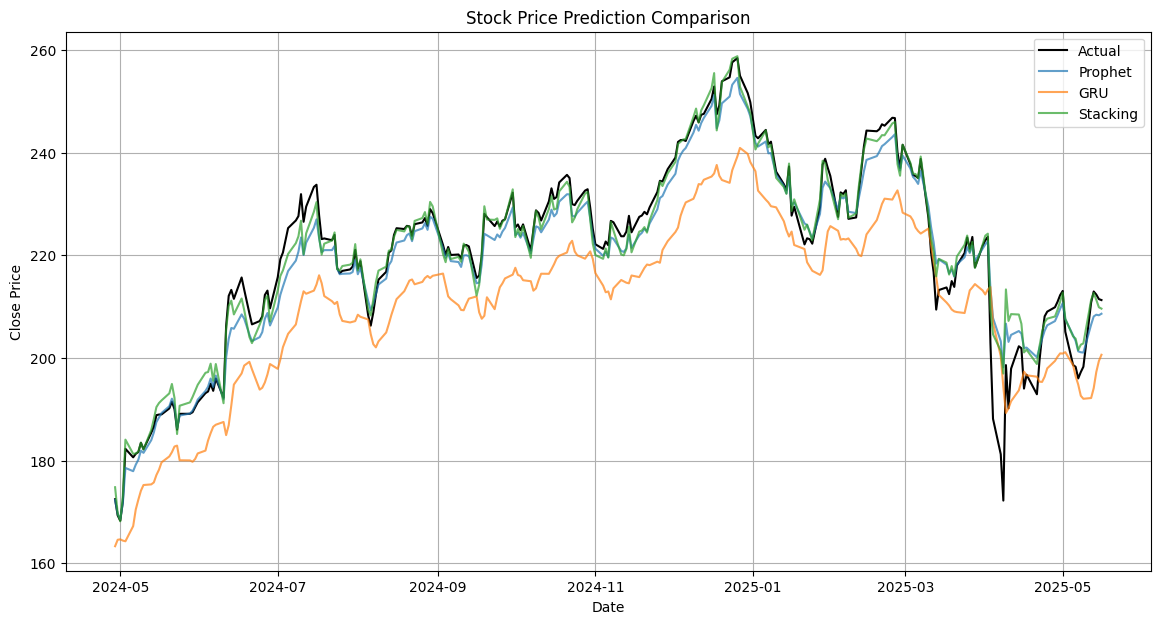

In [30]:
if __name__ == '__main__':
    main()